In [ ]:
import pandas as pd
import numpy as np

from pathlib import Path

In [ ]:
project_root = Path("C://Users//DELL//Desktop//the-year-25-26//scalable-graph-based-movie-recommender")

In [ ]:
movies = pd.read_csv(project_root / 'data' / 'processed' / 'movies_gnn.csv')
ratings = pd.read_csv(project_root / 'data' / 'processed' / 'ratings_gnn.csv')
tags = pd.read_csv(project_root / 'data' / 'processed' / 'tags_gnn.csv')
genome_scores= pd.read_csv(project_root / 'data' / 'processed' / 'genome_scores_gnn.csv')
genome_tags= pd.read_csv(project_root / 'data' / 'processed' / 'genome_tags_gnn.csv')


### Data Resampling Pipeline

The aim is to reduce computational requirements while maintaining a representative subset of the original dataset's collaborative filtering patterns and user-item interaction graph structure.

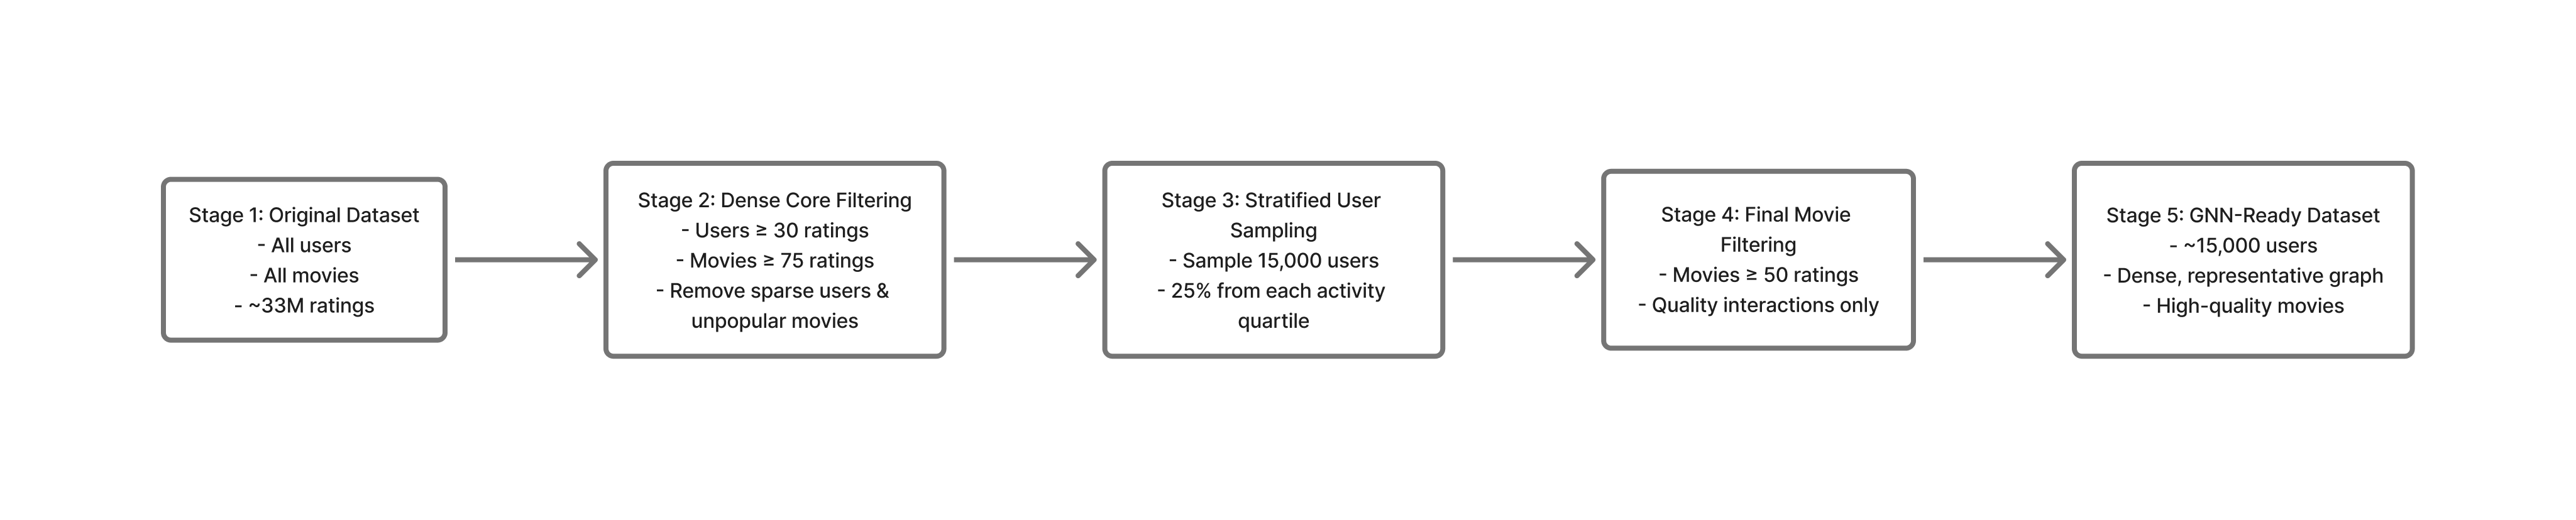

In [ ]:
from IPython.display import Image, display

display(Image(filename='../docs/MovieLens 33M Resampling Pipeline.png'))

In [ ]:
# Create dense core
min_user_ratings = 30
min_movie_ratings = 75

user_counts = ratings['userId'].value_counts()
movie_counts = ratings['movieId'].value_counts()

valid_users = user_counts[user_counts >= min_user_ratings].index
valid_movies = movie_counts[movie_counts >= min_movie_ratings].index

ratings_dense = ratings[
    ratings['userId'].isin(valid_users) & 
    ratings['movieId'].isin(valid_movies)
]

# Sample users while maintaining graph properties
n_users = 15000  # Adjust based on your compute

# Stratified sampling by activity level
user_activity = ratings_dense['userId'].value_counts()
user_activity_bins = pd.qcut(user_activity, q=4, labels=['low', 'med', 'high', 'very_high'])

sampled_users = []
np.random.seed(42)
for bin_label in ['low', 'med', 'high', 'very_high']:
    bin_users = user_activity_bins[user_activity_bins == bin_label].index
    sample_size = int(n_users * 0.25)  # Equal representation
    sampled = np.random.choice(bin_users, size=min(sample_size, len(bin_users)), replace=False)
    sampled_users.extend(sampled)

# Filter ratings
ratings_gnn = ratings_dense[ratings_dense['userId'].isin(sampled_users)]

# Filter movies that still have enough ratings
movie_counts_final = ratings_gnn['movieId'].value_counts()
valid_movies_final = movie_counts_final[movie_counts_final >= 50].index
ratings_gnn = ratings_gnn[ratings_gnn['movieId'].isin(valid_movies_final)]


In [ ]:
print(f"Original: {len(ratings):,} ratings")
print(f"GNN Dataset: {len(ratings_gnn):,} ratings")
print(f"Users: {ratings_gnn['userId'].nunique():,}")
print(f"Movies: {ratings_gnn['movieId'].nunique():,}")
print(f"Sparsity: {1 - len(ratings_gnn) / (ratings_gnn['userId'].nunique() * ratings_gnn['movieId'].nunique()):.4f}")

In [ ]:

# filter corresponding data
movies_gnn = movies[movies['movieId'].isin(ratings_gnn['movieId'])]
tags_gnn = tags[
    (tags['movieId'].isin(ratings_gnn['movieId'])) & 
    (tags['userId'].isin(ratings_gnn['userId']))
]
genome_scores_gnn = genome_scores[genome_scores['movieId'].isin(ratings_gnn['movieId'])]

# Keep ALL tags 
# No need to filter since it's a reference table
genome_tags_gnn = genome_tags.copy()

In [ ]:
# Save
ratings_gnn.to_csv('ratings_gnn.csv', index=False)
movies_gnn.to_csv('movies_gnn.csv', index=False)
tags_gnn.to_csv('tags_gnn.csv', index=False)
genome_scores_gnn.to_csv('genome_scores_gnn.csv', index=False)
genome_tags_gnn.to_csv('genome_tags_gnn.csv', index=False)

In [ ]:
print(f"  Ratings: {len(ratings_gnn):,}")
print(f"  Movies: {len(movies_gnn):,}")
print(f"  Tags: {len(tags_gnn):,}")
print(f"  Genome Scores: {len(genome_scores_gnn):,}")
print(f"  Genome Tags: {len(genome_tags_gnn):,} (full vocabulary)")